In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Display settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)  # ✅ Fixed: (width, height)
plt.rcParams['font.size'] = 12

print("=" * 60)
print("PREPROCESSING PIPELINE INITIALIZATION")
print("=" * 60)
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print("=" * 60)
print("✅ All libraries imported!")
print("=" * 60)


PREPROCESSING PIPELINE INITIALIZATION
OpenCV version: 4.9.0
NumPy version: 1.26.4
Matplotlib version: 3.8.3
✅ All libraries imported!


In [6]:
# ============================================================
# LEAF PREPROCESSOR CLASS
# ============================================================
# Handles all 10-step preprocessing pipeline

class LeafPreprocessor:
    """
    Complete leaf image preprocessing pipeline
    
    Steps:
    1. Load image
    2. Convert to grayscale
    3. Denoise
    4. Apply thresholding
    5. Morphological operations
    6. Find leaf contour
    7. Create mask
    8. Extract leaf
    9. Resize to 224×224
    10. Normalize to 0-1 range
    """
    
    def __init__(self, target_size=(224, 224)):
        """Initialize preprocessor with target output size"""
        self.target_size = target_size
        self.successful = 0
        self.failed = 0
    
    def preprocess_single_image(self, image_path):
        """
        Process ONE image through complete pipeline
        
        Args:
            image_path: Path to leaf image
            
        Returns:
            numpy array: Preprocessed image (224×224, normalized)
            or None if failed
        """
        
        try:
            # STEP 1: Load image
            img = cv2.imread(image_path)
            if img is None:
                print(f"❌ Could not load: {image_path}")
                self.failed += 1
                return None
            
            # STEP 2: Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # STEP 3: Denoise
            denoised = cv2.fastNlMeansDenoising(gray, None, 10, 10, 21)
            
            # STEP 4: Apply Otsu's thresholding
            _, thresh = cv2.threshold(
                denoised, 0, 255,
                cv2.THRESH_BINARY + cv2.THRESH_OTSU
            )
            
            # STEP 5: Morphological closing (fill holes)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
            
            # STEP 6: Find contours
            contours, _ = cv2.findContours(
                closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )
            
            if not contours:
                print(f"⚠️ No contour found: {image_path}")
                self.failed += 1
                return None
            
            # Get largest contour (the leaf)
            largest_contour = max(contours, key=cv2.contourArea)
            contour_area = cv2.contourArea(largest_contour)
            
            if contour_area < 100:
                print(f"⚠️ Leaf too small: {image_path}")
                self.failed += 1
                return None
            
            # STEP 7: Create binary mask
            mask = np.zeros(gray.shape, np.uint8)
            cv2.drawContours(mask, [largest_contour], -1, 255, -1)
            
            # STEP 8: Extract leaf using mask
            leaf = cv2.bitwise_and(gray, gray, mask=mask)
            
            # STEP 9: Resize to standard size
            leaf_resized = cv2.resize(leaf, self.target_size)
            
            # STEP 10: Normalize to 0-1 range
            leaf_normalized = leaf_resized.astype(np.float32) / 255.0
            
            # Track success
            self.successful += 1
            return leaf_normalized
        
        except Exception as e:
            print(f"❌ Error: {str(e)}")
            self.failed += 1
            return None

# Create processor instance
processor = LeafPreprocessor(target_size=(224, 224))
print("✅ LeafPreprocessor class created!")


✅ LeafPreprocessor class created!


🐛 Testing path: C:\Users\Sai Sree\Downloads\PlantID-Capstone\data\raw\Leaves\1001.jpg
✅ Exists: True
📷 Testing on: 1001.jpg
------------------------------------------------------------


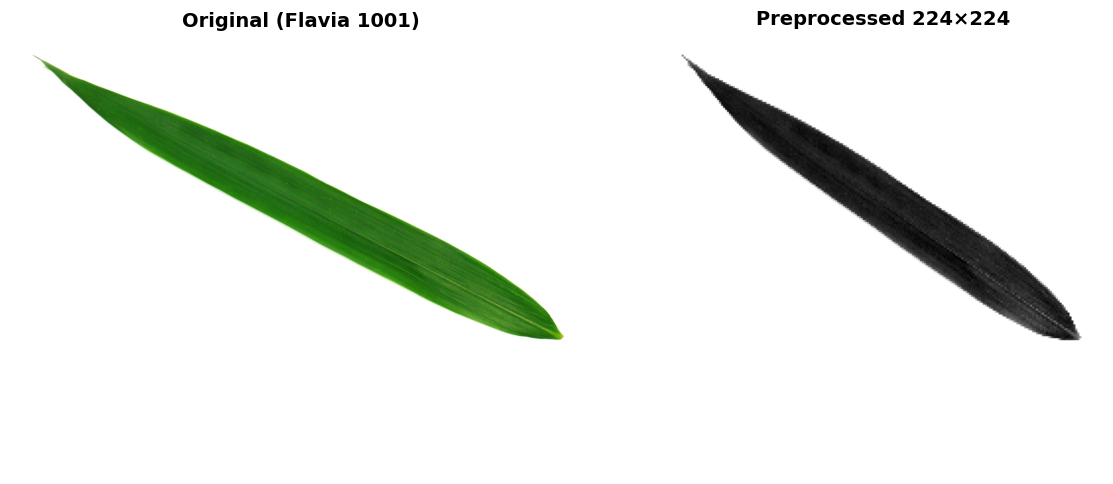

✅ PREPROCESSING SUCCESSFUL!
📊 Shape: (224, 224)
📈 Range: [0.227, 1.000]


In [14]:
# ============================================================
# TEST ON SINGLE IMAGE FROM FLAVIA
# ============================================================

# ✅ ABSOLUTE PATH (guaranteed to work)
test_image_path = r'C:\Users\Sai Sree\Downloads\PlantID-Capstone\data\raw\Leaves\1001.jpg'

print(f"🐛 Testing path: {test_image_path}")
print(f"✅ Exists: {os.path.exists(test_image_path)}")

if os.path.exists(test_image_path):
    print(f"📷 Testing on: {os.path.basename(test_image_path)}")
    print("-" * 60)
    
    processed = processor.preprocess_single_image(test_image_path)
    
    if processed is not None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Original
        original = cv2.imread(test_image_path)
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        axes[0].imshow(original_rgb)
        axes[0].set_title('Original (Flavia 1001)', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        
        # Processed
        axes[1].imshow(processed, cmap='gray')
        axes[1].set_title('Preprocessed 224×224', fontsize=14, fontweight='bold')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("=" * 60)
        print("✅ PREPROCESSING SUCCESSFUL!")
        print(f"📊 Shape: {processed.shape}")
        print(f"📈 Range: [{processed.min():.3f}, {processed.max():.3f}]")
        print("=" * 60)
    else:
        print("❌ Preprocessing failed")
else:
    print("❌ File missing")


In [15]:
# ============================================================
# BATCH PROCESS FLAT LEAVES FOLDER (SIMPLE VERSION)
# ============================================================

input_dir = r'C:\Users\Sai Sree\Downloads\PlantID-Capstone\data\raw\Leaves'
output_dir = r'C:\Users\Sai Sree\Downloads\PlantID-Capstone\data\processed\all_leaves'

os.makedirs(output_dir, exist_ok=True)

# Get all JPGs
import glob
image_files = glob.glob(os.path.join(input_dir, '*.jpg'))
print(f"🔄 Processing {len(image_files)} images from flat folder...")

success = 0
for i, img_path in enumerate(image_files):
    processed = processor.preprocess_single_image(img_path)
    if processed is not None:
        filename = os.path.basename(img_path).replace('.jpg', '.png')
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, (processed * 255).astype(np.uint8))
        success += 1
    
    if (i+1) % 50 == 0:
        print(f"⏳ {i+1}/{len(image_files)}")

print(f"\n✅ {success}/{len(image_files)} successful!")
print(f"📁 Output: {output_dir}")


🔄 Processing 1907 images from flat folder...
⏳ 50/1907
⏳ 100/1907
⏳ 150/1907
⏳ 200/1907
⏳ 250/1907
⏳ 300/1907
⏳ 350/1907
⏳ 400/1907
⏳ 450/1907
⏳ 500/1907
⏳ 550/1907
⏳ 600/1907
⏳ 650/1907
⏳ 700/1907
⏳ 750/1907
⏳ 800/1907
⏳ 850/1907
⏳ 900/1907
⏳ 950/1907
⏳ 1000/1907
⏳ 1050/1907
⏳ 1100/1907
⏳ 1150/1907
⏳ 1200/1907
⏳ 1250/1907
⏳ 1300/1907
⏳ 1350/1907
⏳ 1400/1907
⏳ 1450/1907
⏳ 1500/1907
⏳ 1550/1907
⏳ 1600/1907
⏳ 1650/1907
⏳ 1700/1907
⏳ 1750/1907
⏳ 1800/1907
⏳ 1850/1907
⏳ 1900/1907

✅ 1907/1907 successful!
📁 Output: C:\Users\Sai Sree\Downloads\PlantID-Capstone\data\processed\all_leaves
